# Pitching Motion Classification

In [ ]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import time
from scipy.interpolate import interp1d
from scipy.signal import resample
import seaborn as sns

In [2]:
# PCA calculation function
# transpose data
def PCA_calcualting(data):

    # standerdize data (needed??)
    # df_segmented_pca_scaled = scale(df_segmented_pca)
    # create PCA object to fit
    # edit here
    pca = PCA(n_components=3) 

    # fit the object to data
    pca.fit(data)

    # append variance_ration to the lists
    # the number of element should match with number of pitchs (thus files)
    variance = (pca.explained_variance_ratio_)
    loading = (pca.components_)
    scores = pca.fit_transform(data)

    return variance, loading, scores

In [3]:
# import data 
path = "/home/yyanagita/data/motion_classification/joint_velos.csv"
df = pd.read_csv(path)

In [6]:
# print head of df
df.head(10)

,session_pitch,time,elbow_velo_x,elbow_velo_y,elbow_velo_z,rear_hip_velo_x,rear_hip_velo_y,rear_hip_velo_z,rear_knee_velo_x,rear_knee_velo_y,...,torso_velo_z,torso_pelvis_velo_x,torso_pelvis_velo_y,torso_pelvis_velo_z,pkh_time,fp_10_time,fp_100_time,MER_time,BR_time,MIR_time
0,1031_2,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
1,1031_2,0.0028,268.0558,-1081.1728,-132.3921,-60.9899,-170.2306,388.7123,-124.3655,-2.1518,...,-23.3659,22.0803,3.9685,5.0452,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
2,1031_2,0.0056,208.5674,-843.5846,-103.2996,-55.0698,-131.7576,310.0950,-99.1835,-1.6739,...,-24.2806,21.6278,3.5474,5.0219,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
3,1031_2,0.0083,151.5794,-617.1972,-75.5779,-49.4129,-94.9223,235.0877,-75.1388,-1.2168,...,-25.2296,21.2070,3.0799,5.0817,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
4,1031_2,0.0111,99.4751,-411.3320,-50.3682,-44.2690,-61.2806,166.8601,-53.2711,-0.7995,...,-26.2045,20.8405,2.5554,5.2453,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
5,1031_2,0.0139,54.2247,-233.5783,-28.5998,-39.8470,-32.1208,108.0145,-34.4445,-0.4376,...,-27.1998,20.5485,1.9620,5.5281,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
6,1031_2,0.0167,17.2323,-89.2108,-10.9182,-36.2979,-8.3643,60.3829,-19.2820,-0.1422,...,-28.2128,20.3468,1.2875,5.9375,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
7,1031_2,0.0194,-10.7556,19.1380,2.3545,-33.7044,9.4935,24.9089,-8.1249,0.0811,...,-29.2431,20.2458,0.5218,6.4722,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
8,1031_2,0.0222,-29.6724,91.5261,11.2256,-32.0776,21.3983,1.6217,-1.0230,0.2317,...,-30.2920,20.2495,-0.3422,7.1216,0.625,1.1806,1.1917,1.3056,1.3389,1.3778
9,1031_2,0.0250,-40.0866,130.4816,16.0046,-31.3605,27.7064,-10.2989,2.2470,0.3146,...,-31.3615,20.3544,-1.3063,7.8662,0.625,1.1806,1.1917,1.3056,1.3389,1.3778


In [4]:
# get uniqu pitch ID
unique_sessions = [i for i in df["session_pitch"].unique()]

uniques = []

for id in unique_sessions:
    uniques.append(id.split("_")[0])

unique_id = []

for x in uniques:
    if x not in unique_id:
        unique_id.append(x)

print(f"number of perticipants: {len(unique_id)}")

number of perticipants: 100


In [ ]:
variance = []
scores = []
X_pca_components = []
loading = []
del_df = []

for id in unique_id:
    del_df = []

    print(f"processing: {id}")

    # data by a pithcer
    df_by_id = df[df["session_pitch"].str.contains(id)]

    # get unique session 
    unique_sessions_by_pitcher = df_by_id["session_pitch"].unique() 

    # create col names by nubmer of pitches
    n_pitchs = len(unique_sessions_by_pitcher)
    # name by pitch following "trinal"
    #cols = [f"trial{i}" for i in n_pitchs]

    dfs = [pd.DataFrame() for _ in range(n_pitchs)]


    for session, n_pitch in zip(unique_sessions_by_pitcher, range(n_pitchs)):

        # get data by session for a pitcher
        df_by_pitch = df_by_id[df_by_id["session_pitch"] == session].reset_index()

        # segment from foot contact to ball release
        fc_time = df_by_pitch["fp_10_time"].unique()
        fc_inx = df_by_pitch[df_by_pitch["time"] == fc_time[0]].index

        br_time = df_by_pitch["BR_time"].unique()
        br_inx = df_by_pitch[df_by_pitch["time"] == br_time[0]].index

        print(fc_inx, br_inx)

        # delet frame if aplicable
        if fc_inx.empty or br_inx.empty or fc_inx > br_inx:
            print(f"data frame {n_pitch} will be deleted")
            del_df.append(n_pitch)
            continue
        
        # segment data form fc to br
        segmented_df = df_by_pitch[fc_inx[0]:br_inx[0]]

        # get columns name
        current_colmuns = segmented_df.columns

        # resample it to 101 data points
        resampled_segmented_data = pd.DataFrame(resample(segmented_df, 101),
                                                    columns=current_colmuns)

        # fill nan if exists
        #resampled_segmented_data = resampled_segmented_data.fillna(method='bfill')
        resampled_segmented_data.drop(columns=["index",
                                               "session_pitch",
                                                "time",
                                                "pkh_time",
                                                "fp_10_time",
                                                "fp_100_time",
                                                "MER_time",
                                                "MIR_time",
                                                "BR_time"], inplace=True)

        # average trials
        dfs[n_pitch] = resampled_segmented_data


        # when the final trial is done 
        if n_pitch +1 == n_pitchs:

            # delete empty dfs
            print(len(dfs))
            for i in del_df:
                del dfs[i]

            # Compute the average across them
            pca_data = sum(dfs) / len(dfs)
            pca_data.dropna(inplace=True)
            if pca_data.empty:
                continue

            print(f"Computing PCA: {id}")
            ratio, loadings, score = PCA_calcualting(pca_data)
            variance.append([id, ratio*100])
            loading.append([id, loadings])
            scores.append([id, score])
            
            # compute and store componentes for visualization
            pca_X = PCA(n_components=3)
            X_pca = pca_X.fit_transform(pca_data) # X_scaled is your preprocessed data
            X_pca_components.append([id, X_pca])
            
        

            time.sleep(1)

            print(f"PCA completed: {id}")


processing: 1031
Index([425], dtype='int64') Index([482], dtype='int64')
Index([239], dtype='int64') Index([297], dtype='int64')
2
Computing PCA: 1031
PCA completed: 1031
processing: 1097
Index([278], dtype='int64') Index([361], dtype='int64')
Index([307], dtype='int64') Index([382], dtype='int64')
Index([301], dtype='int64') Index([371], dtype='int64')
3
Computing PCA: 1097
PCA completed: 1097
processing: 1170
Index([355], dtype='int64') Index([420], dtype='int64')
Index([317], dtype='int64') Index([377], dtype='int64')
2
Computing PCA: 1170
PCA completed: 1170
processing: 1250
Index([227], dtype='int64') Index([280], dtype='int64')
Index([237], dtype='int64') Index([288], dtype='int64')
2
Computing PCA: 1250
PCA completed: 1250
processing: 1313
Index([328], dtype='int64') Index([397], dtype='int64')
Index([307], dtype='int64') Index([376], dtype='int64')
Index([334], dtype='int64') Index([400], dtype='int64')
3
Computing PCA: 1313
PCA completed: 1313
processing: 1346
Index([329], dty

In [6]:
joint_velo_names = pca_data.columns
df_loadings = pd.DataFrame(loadings, columns=joint_velo_names, index=['PC1', 'PC2', 'PC3'])
df_loadings.round(2)

,elbow_velo_x,elbow_velo_y,elbow_velo_z,rear_hip_velo_x,rear_hip_velo_y,rear_hip_velo_z,rear_knee_velo_x,rear_knee_velo_y,rear_knee_velo_z,shoulder_velo_x,...,glove_shoulder_velo_z,glove_wrist_velo_x,glove_wrist_velo_y,glove_wrist_velo_z,torso_velo_x,torso_velo_y,torso_velo_z,torso_pelvis_velo_x,torso_pelvis_velo_y,torso_pelvis_velo_z
PC1,0.49,-0.08,-0.06,-0.09,0.05,-0.03,-0.03,-0.0,0.0,0.07,...,0.02,-0.11,-0.03,-0.02,-0.09,-0.03,-0.05,-0.09,-0.03,-0.04
PC2,0.44,-0.21,0.04,-0.21,0.02,0.18,-0.13,-0.0,-0.0,-0.31,...,0.07,-0.33,0.06,0.05,-0.17,0.01,0.11,-0.25,0.06,-0.16
PC3,0.52,-0.25,0.04,0.02,0.00,-0.24,-0.02,-0.0,0.0,0.14,...,-0.02,0.20,-0.04,-0.04,0.13,-0.04,-0.18,0.20,-0.22,0.12


In [8]:
#df_scores = pd.DataFrame(scores, columns=['PC1', 'PC2', 'PC3'])
scores

[['1031',
  array([[ -913.81771493,  1101.76134843,   426.95248549],
         [-1693.52675091,  1120.72739144,   745.69591947],
         [ -706.08245129,  1071.57816443,   331.08415312],
         [ -618.51331974,  1056.46706406,   287.33370828],
         [-1221.89898391,  1066.11914319,   533.49764583],
         [-1110.47060457,  1049.00189806,   478.69390764],
         [ -763.93805432,  1022.99744474,   322.57803204],
         [-1003.0063564 ,  1017.66764656,   412.59408023],
         [-1215.07030762,  1010.86505746,   490.74287247],
         [ -987.26380557,   987.89685714,   380.88773022],
         [ -944.41451452,   971.11550421,   347.36288594],
         [-1189.87237048,   964.15097329,   435.15452297],
         [-1174.23346051,   947.47177298,   410.73206608],
         [-1018.22334327,   925.37761293,   324.1774213 ],
         [-1138.02727611,   912.58540429,   352.93493103],
         [-1270.46021545,   899.74785785,   385.76817456],
         [-1159.2767923 ,   877.78420107,   31

In [10]:
pcs_data = pd.DataFrame(variance, columns=["ID", "variance"])
pcs_data["pc1"] = pcs_data["variance"].str[0]
pcs_data["pc2"] = pcs_data["variance"].str[1]
pcs_data["pc3"] = pcs_data["variance"].str[2]
pcs_data["total"] = pcs_data["variance"].apply(sum)

pcs_data


,ID,variance,pc1,pc2,pc3,total
0,1031,"[78.98920251473818, 11.047130542824632, 7.0570...",78.989203,11.047131,7.057037,97.093370
1,1097,"[66.78486629509702, 20.74672696295517, 6.68606...",66.784866,20.746727,6.686070,94.217663
2,1170,"[76.5352749333485, 13.310502958315764, 6.66793...",76.535275,13.310503,6.667933,96.513710
3,1250,"[76.66681443471343, 15.82112904088254, 4.53065...",76.666814,15.821129,4.530651,97.018594
4,1313,"[69.36674572606105, 19.66147304842739, 6.26593...",69.366746,19.661473,6.265938,95.294157
...,...,...,...,...,...,...
93,3233,"[78.45892014630664, 12.432798250400309, 5.7935...",78.458920,12.432798,5.793508,96.685226
94,3247,"[72.8840872657654, 17.365261448012216, 6.62035...",72.884087,17.365261,6.620351,96.869700
95,3248,"[79.7966547977447, 11.865713143961605, 5.43725...",79.796655,11.865713,5.437255,97.099623
96,3250,"[80.10265578689612, 13.22764789062143, 4.34041...",80.102656,13.227648,4.340418,97.670722


In [11]:
pcs_components_data = pd.DataFrame(X_pca_components, columns=["ID", "components"])
pcs_components_data["pc1"] = pcs_components_data["components"].str[0]
pcs_components_data["pc2"] = pcs_components_data["components"].str[1]
pcs_components_data["pc3"] = pcs_components_data["components"].str[2]

pcs_components_data

,ID,components,pc1,pc2,pc3
0,1031,"[[-913.8177149298662, 1101.761348431198, 426.9...","[-913.8177149298662, 1101.761348431198, 426.95...","[-1693.5267509088367, 1120.7273914430073, 745....","[-706.0824512916932, 1071.5781644347426, 331.0..."
1,1097,"[[-541.217091463467, 1458.1130190491554, -311....","[-541.217091463467, 1458.1130190491554, -311.5...","[-995.2375015351256, 1438.6313454447663, -423....","[-196.84515022743417, 1385.5005364075905, -208..."
2,1170,"[[-699.4221420374133, -544.1736851069534, -847...","[-699.4221420374133, -544.1736851069534, -847....","[-1349.5825594817413, -284.8199013877323, -103...","[-424.52928993252476, -613.8975414509276, -754..."
3,1250,"[[-756.997115756161, -1328.5336725479428, 467....","[-756.997115756161, -1328.5336725479428, 467.5...","[-1474.2400268054555, -1301.5368502381684, 733...","[-714.602288411126, -1284.3224716094987, 448.9..."
4,1313,"[[-482.6603463752024, -977.4397275848416, -693...","[-482.6603463752024, -977.4397275848416, -693....","[-1062.6072720429347, -887.5608596007032, -813...","[-138.99482280716737, -1015.5585934893908, -57..."
...,...,...,...,...,...
93,3233,"[[-568.2526144723578, -664.7377073584994, 819....","[-568.2526144723578, -664.7377073584994, 819.6...","[-1292.8315624371112, -510.31362694093025, 107...","[-404.5580520812941, -699.0948304718719, 743.4..."
94,3247,"[[-1208.7737791617117, -742.584434111687, 717....","[-1208.7737791617117, -742.584434111687, 717.6...","[-2013.6350207736218, -600.1908598496021, 980....","[-1117.8154243107037, -767.0011974642887, 689...."
95,3248,"[[-846.4305058140985, -393.8639611392617, 1006...","[-846.4305058140985, -393.8639611392617, 1006....","[-1684.138676345411, -127.86050032794365, 1180...","[-875.5910966365068, -382.7904957379089, 989.6..."
96,3250,"[[27.872758659283864, -1182.376870557264, 381....","[27.872758659283864, -1182.376870557264, 381.0...","[-555.1253301241584, -1175.4686911949584, 589....","[184.82983350356474, -1127.719705293746, 325.5..."


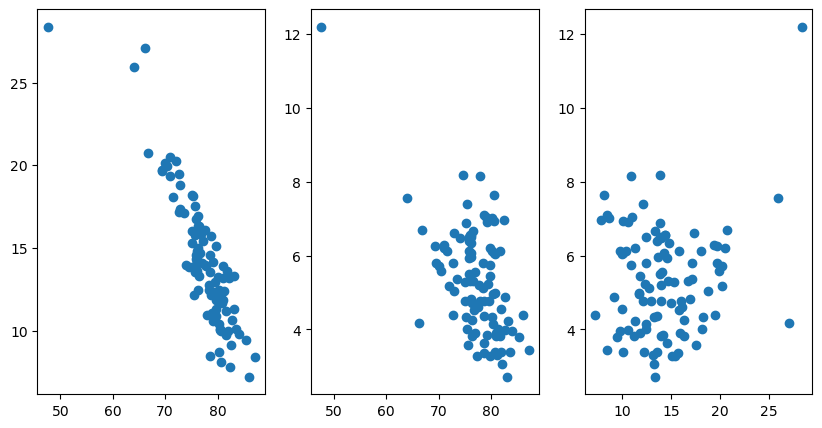

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))

ax[0].scatter(x=pcs_data["pc1"],
              y=pcs_data["pc2"])

ax[1].scatter(x=pcs_data["pc1"],
              y=pcs_data["pc3"])

ax[2].scatter(x=pcs_data["pc2"],
              y=pcs_data["pc3"])

In [13]:
from sklearn.cluster import KMeans

In [14]:
# Cluster into 3 groups
clustering_data = pcs_data[["pc1","pc2","pc3"]]
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_data)
pcs_data["cluster"] = clusters

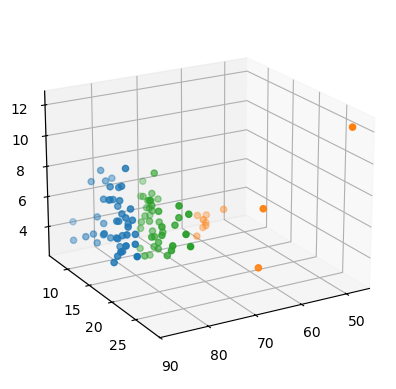

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cluster = pcs_data["cluster"].unique()


for i in cluster:

    data = pcs_data[pcs_data["cluster"] == i]

    ax.scatter(data=data,
            xs="pc1",
            ys="pc2",
            zs="pc3",
            label=f"cluster{i}")

ax.view_init(20, 60)


In [ ]:
# import point matrix
path = "/home/yyanagita/data/motion_classification/poi_metrics.csv"
poi_df = pd.read_csv(path)

# import meta data
path = "/home/yyanagita/data/motion_classification/metadata.csv"
meta_df = pd.read_csv(path)


,user,session,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph,filename_new,modelname_new
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d
3,774,1097,1097_2,101.1528,1.9304,19.41,college,77.0,000774_001097_76_223_005_FF_770.c3d,000774_001097_model.c3d
4,774,1097,1097_3,101.1528,1.9304,19.41,college,76.1,000774_001097_76_223_006_FF_761.c3d,000774_001097_model.c3d


In [ ]:
meta_df = meta_df.drop_duplicates(subset="session")[["session", "session_mass_kg", "session_height_m", "age_yrs", "playing_level"]]

count         100
unique          4
top       college
freq           75
Name: playing_level, dtype: object

In [28]:
# count throwing hand by college players
throw_count = pd.merge(poi_df, meta_df, left_on="session", right_on="session")
throw_count = throw_count.drop_duplicates(subset="session")
throw_count = throw_count[throw_count["playing_level"] == "college"]["p_throws"].value_counts()
throw_count

p_throws
R    60
L    15
Name: count, dtype: int64

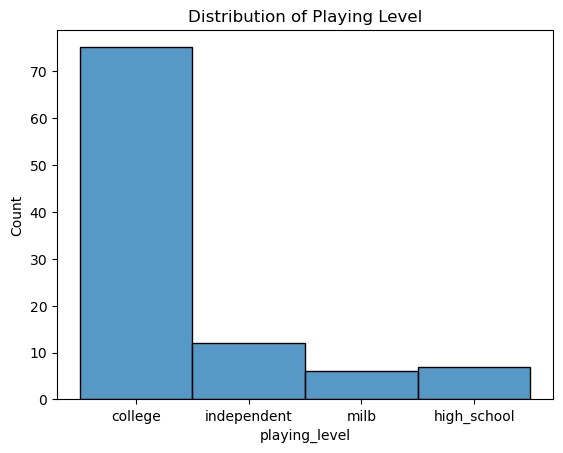

In [6]:
import seaborn as sns


sns.histplot(data=meta_df, x="playing_level")
plt.title("Distribution of Playing Level")

plt.show()


In [18]:
elbow_varus_moment = poi_df.groupby("session", as_index=False)["elbow_varus_moment"].mean()

In [19]:
pitch_speed = meta_df.groupby("session", as_index=False)["pitch_speed_mph"].mean()
pitch_speed["session"].astype(str)

KeyError: 'Column not found: pitch_speed_mph'

In [ ]:
pcs_data.rename(columns={"ID":"session"}, inplace=True)
pcs_data["session"] = pcs_data["session"].astype(int)


In [ ]:
merged_df = pcs_data.merge(pitch_speed, on="session", how="inner")
merged_df = merged_df.merge(elbow_varus_moment, on="session", how="inner")
merged_df = merged_df.merge(meta_df, on="session", how="inner")

In [ ]:
merged_df.head(10)
merged_df.value_counts()

playing_level
college        73
independent    12
high_school     7
milb            6
Name: count, dtype: int64

In [ ]:
merged_df = merged_df[merged_df["playing_level"] == "college"]

In [ ]:
merged_df.groupby("cluster")["pitch_speed_mph"].mean()


cluster
0    84.996176
1    84.621324
2    84.813333
Name: pitch_speed_mph, dtype: float64

/tmp/ipykernel_1156/3056776489.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=merged_df["cluster"],


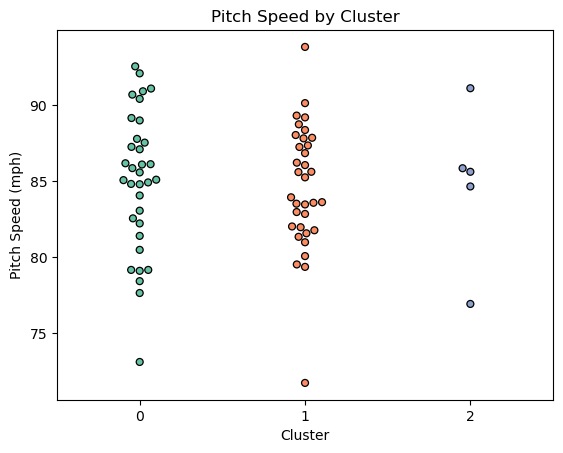

In [ ]:
# plot by cluster
import seaborn as sns
fig, ax = plt.subplots()

sns.swarmplot(x=merged_df["cluster"],
              y=merged_df["pitch_speed_mph"],
              ax=ax,
              palette='Set2', # Point color
              edgecolor='black', # Edge color
              linewidth=0.9, # Edge size
                )

plt.xlabel('Cluster')
plt.ylabel('Pitch Speed (mph)')
plt.title("Pitch Speed by Cluster")
plt.show()

In [ ]:
merged_df.groupby("cluster")["elbow_varus_moment"].mean()

cluster
0    111.427086
1    108.542866
2    112.084168
Name: elbow_varus_moment, dtype: float64

/tmp/ipykernel_1156/1278786906.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x=merged_df["cluster"],


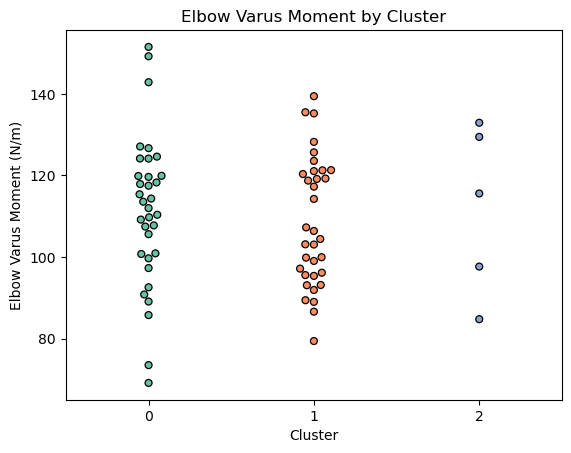

In [ ]:
fig, ax = plt.subplots()

sns.swarmplot(x=merged_df["cluster"],
              y=merged_df["elbow_varus_moment"],
              ax=ax,
              palette='Set2', # Point color
              edgecolor='black', # Edge color
              linewidth=0.9, # Edge size
                )

plt.xlabel('Cluster')
plt.ylabel('Elbow Varus Moment (N/m)')
plt.title("Elbow Varus Moment by Cluster")
plt.show()

In [ ]:
import statsmodels.formula.api as smf
model = smf.mixedlm("elbow_varus_moment ~ C(cluster)", merged_df, groups=merged_df["session"])
result = model.fit()

# Print the model summary, which includes fixed effects estimates and p-values
print(result.summary())

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: elbow_varus_moment
No. Observations: 73      Method:             REML              
No. Groups:       73      Scale:              149.9669          
Min. group size:  1       Log-Likelihood:     -303.2814         
Max. group size:  1       Converged:          Yes               
Mean group size:  1.0                                           
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept         111.427    0.504 221.291 0.000 110.440 112.414
C(cluster)[T.1]    -2.884    3.316  -0.870 0.384  -9.383   3.614
C(cluster)[T.2]     0.657    7.334   0.090 0.929 -13.718  15.032
Group Var         149.967                                       



/home/yyanagita/anaconda3/envs/Dissertation/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
model = smf.mixedlm("pitch_speed_mph ~ elbow_varus_moment * C(cluster)", merged_df, groups=merged_df["cluster"])
result = model.fit()

# Print the model summary, which includes fixed effects estimates and p-values
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      pitch_speed_mph
No. Observations:        73           Method:                  REML           
No. Groups:              3            Scale:                   16.3793        
Min. group size:         5            Log-Likelihood:          -205.9484      
Max. group size:         34           Converged:               Yes            
Mean group size:         24.3                                                 
------------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          72.240    5.923 12.196 0.000  60.631 83.849
C(cluster)[T.1]                     0.170    8.699  0.020 0.984 -16.880 17.219
C(cluster)[T.2]                    21.233   13.253  1.602 0.109  -4.741 4

/home/yyanagita/anaconda3/envs/Dissertation/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


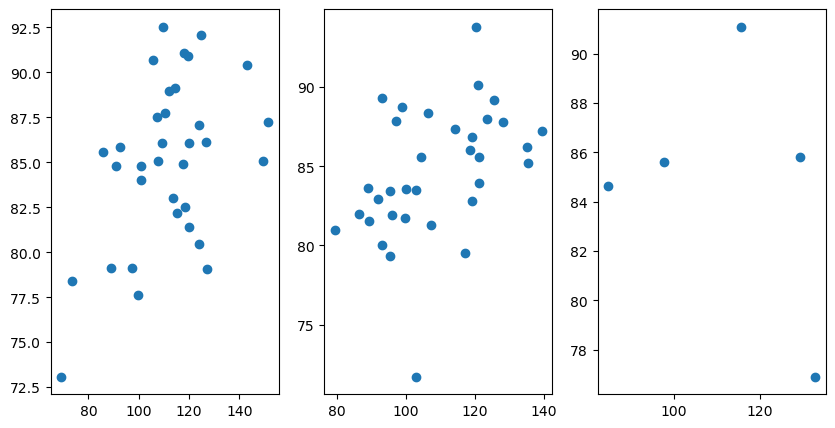

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))

ax[0].scatter(merged_df["elbow_varus_moment"][merged_df["cluster"] == 0],
             merged_df["pitch_speed_mph"][merged_df["cluster"] == 0])

ax[1].scatter(merged_df["elbow_varus_moment"][merged_df["cluster"] == 1],
             merged_df["pitch_speed_mph"][merged_df["cluster"] == 1])

ax[2].scatter(merged_df["elbow_varus_moment"][merged_df["cluster"] == 2],
             merged_df["pitch_speed_mph"][merged_df["cluster"] == 2])

In [ ]:
model = smf.mixedlm("pitch_speed_mph ~ C(cluster)", merged_df, groups=merged_df["session"])
result = model.fit()

# Print the model summary, which includes fixed effects estimates and p-values
print(result.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: pitch_speed_mph
No. Observations: 73      Method:             REML           
No. Groups:       73      Scale:              9.6913         
Min. group size:  1       Log-Likelihood:     -207.4098      
Max. group size:  1       Converged:          Yes            
Mean group size:  1.0                                        
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept         84.996    0.243 350.133 0.000 84.520 85.472
C(cluster)[T.1]   -0.375    0.502  -0.747 0.455 -1.359  0.609
C(cluster)[T.2]   -0.183    1.890  -0.097 0.923 -3.886  3.521
Group Var          9.691                                     



/home/yyanagita/anaconda3/envs/Dissertation/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
